In [3]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

In [1]:
!nvidia-smi

Fri Jan 13 02:44:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
%pwd

'/kaggle/working'

In [6]:
data_dir = '../input/hotdognothotdog'

In [7]:
!ls ../input/

hotdognothotdog


In [8]:
#transform = transforms.Compose([transforms.ToTensor()]) 

In [9]:
transform = transforms.Compose([transforms.Resize(size = (299, 299)), 
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomRotation(degrees = (0, 20)),
                                transforms.ToTensor()
                                ]) 

In [10]:
trainset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/train', transform=transform)
testset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/test', transform=transform)

In [11]:
trainset, validset = random_split(trainset, [2400, 600])

In [12]:
print(type(trainset), len(trainset)) # 3000
print(type(validset), len(validset))
print(type(testset), len(testset)) # 644

<class 'torch.utils.data.dataset.Subset'> 2400
<class 'torch.utils.data.dataset.Subset'> 600
<class 'torchvision.datasets.folder.ImageFolder'> 644


In [13]:
# 0번째 샘플 이미지
trainset[0][0].size(), trainset[0][1]

(torch.Size([3, 299, 299]), 1)

In [14]:
# 1번 샘플
sample_img = trainset[1][0]
sample_img.size()

torch.Size([3, 299, 299])

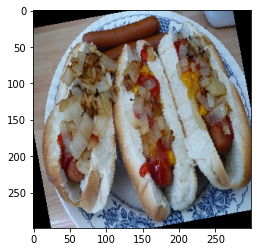

In [15]:
plt.imshow(sample_img.permute(1, 2, 0))

In [16]:
sample_img.size()

torch.Size([3, 299, 299])

In [17]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(3, 299, 299)

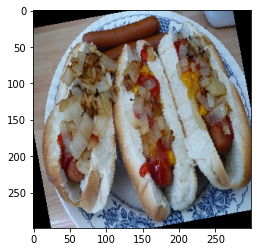

In [18]:
plt.imshow(numpy_sample.transpose(1, 2, 0))

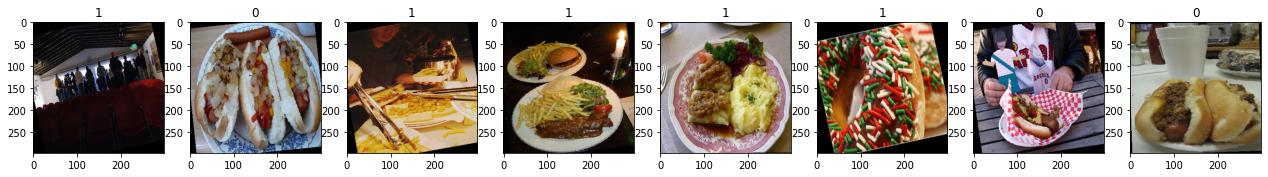

In [19]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
    axes[i].imshow(trainset[i][0].permute(1, 2, 0))
    axes[i].set_title(trainset[i][1])   

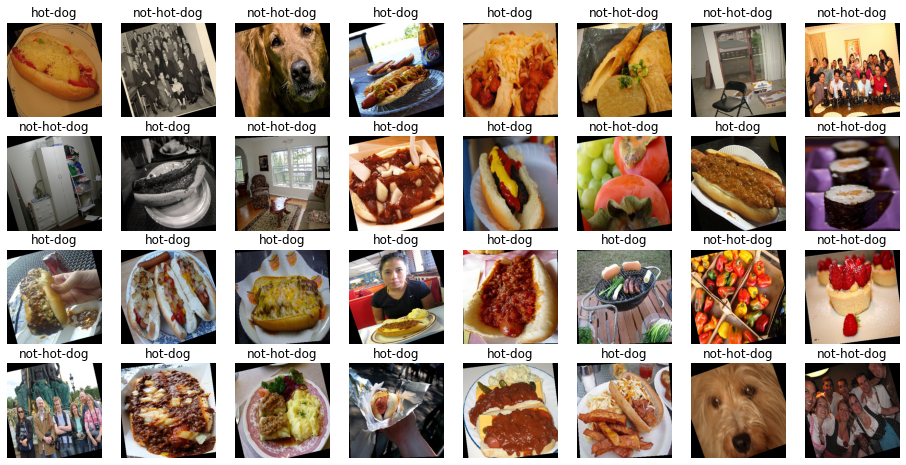

In [20]:
labels_map = {0 : 'hot-dog', 1 : 'not-hot-dog'}  

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    image = trainset[rand_i][0].permute(1, 2, 0)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[trainset[rand_i][1]])   

3. 데이터 적재

In [21]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) 
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) 

In [22]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 150
<class 'torch.utils.data.dataloader.DataLoader'> 38
<class 'torch.utils.data.dataloader.DataLoader'> 41


In [23]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([16, 3, 299, 299]) torch.Size([16])


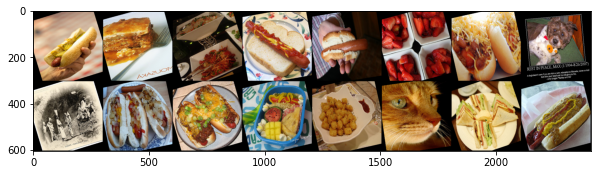

In [24]:
gird_img = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 100))
plt.imshow(gird_img.permute(1, 2, 0))

4. 모델생성

In [25]:
from torch import nn 
from torch import optim 
import torch.nn.functional as F 

In [26]:
import torchvision.models as models
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [27]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[ 0.4984, -1.4400,  0.2089,  1.2447, -0.1047],
        [ 0.1564, -0.2808, -0.6367,  0.0933, -1.6566],
        [ 0.2827, -1.0541,  0.5407,  0.5793, -1.3005]])

In [28]:
import math
b = torch.empty(3)
bound = 1 / math.sqrt(w.size(1))
nn.init.uniform_(b, -bound, bound)

tensor([-0.1762,  0.3636,  0.3955])

In [29]:
#class AlexNet(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.features = nn.Sequential(
#            # 1st block
#            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, padding=1),
#            nn.BatchNorm2d(96),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2), # 96 x 112 x 112
#            # 2nd block
#            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
#            nn.BatchNorm2d(256),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 56 x 56
#            # 3rd block
#            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
#            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
#            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2) # 256 x 28 x 28
#        )

#        self.classifier = nn.Sequential(
#            nn.Dropout(0.5),
#            nn.Linear(in_features=256*28*28, out_features=1024), 
#            nn.BatchNorm1d(1024),
#            nn.ReLU(),
#            nn.Dropout(0.3),
#            nn.Linear(in_features=1024, out_features=512), 
#            nn.BatchNorm1d(512),
#            nn.ReLU(),
#            nn.Linear(in_features=512, out_features=2)    
#        )
#
#    def forward(self, x):
#        x = self.features(x)
#        x = x.view(-1, 256*28*28)  # flatten
#        x = self.classifier(x)
#        return x

In [31]:
model.classifier[6] = nn.Sequential(
                        nn.Linear(4096, 1000),
                        nn.Dropout(0.2),
                        nn.Linear(1000,2)
                      )

In [32]:
#model = AlexNet()
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
!pip install torchsummary

In [34]:
from torchsummary import summary

In [35]:
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 74, 74]          23,296
              ReLU-2           [-1, 64, 74, 74]               0
         MaxPool2d-3           [-1, 64, 36, 36]               0
            Conv2d-4          [-1, 192, 36, 36]         307,392
              ReLU-5          [-1, 192, 36, 36]               0
         MaxPool2d-6          [-1, 192, 17, 17]               0
            Conv2d-7          [-1, 384, 17, 17]         663,936
              ReLU-8          [-1, 384, 17, 17]               0
            Conv2d-9          [-1, 256, 17, 17]         884,992
             ReLU-10          [-1, 256, 17, 17]               0
           Conv2d-11          [-1, 256, 17, 17]         590,080
             ReLU-12          [-1, 256, 17, 17]               0
        MaxPool2d-13            [-1, 256, 8, 8]               0
AdaptiveAvgPool2d-14            [-1, 25

5. 모델 컴바인

In [36]:
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [37]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

6. 모델훈련(with 검증)

In [38]:
def validation(model, validloader, criterion):
    valid_accuracy = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) # 16개에 대한 loss
      
            valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴
        

    return valid_loss, valid_accuracy 

In [39]:
from torch.utils.tensorboard import SummaryWriter
writer  = SummaryWriter()

In [40]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 10 # for Early stopping
    
    train_loss_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    # 1 에폭(epoch)당 반복수
    #steps_per_epoch = len(trainset)/batch_size # 21.75 iterations
    steps_per_epoch = len(trainloader) # 21.75 iterations

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader):
            steps += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0:
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_accuracy = validation(model, validloader, criterion)
                
                ###
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                valid_acc_list.append(valid_accuracy/len(validloader))
                
                # tensorboad 시각화
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                   'valid' : valid_loss/len(validloader)}, epoch)
        
                writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


                print('Epoch : {}/{}.....'.format(epoch+1, epochs),
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
        
                # Best model 저장
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')

                # Early Stopping 
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                    else:
                        trigger = 0
                        min_loss = valid_loss

                    train_loss = 0
                    model.train()
                    # Learning Rate Scheduler
                    scheduler.step(valid_loss)
        writer.flush()      

In [ ]:
epochs=55
train(model, epochs, criterion, optimizer)

In [71]:
%load_ext tensorboard

In [83]:
%tensorboard --logdir=runs

In [84]:
writer.close()

7. 모델 예측

In [72]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([18, 3, 299, 299]) torch.Size([18])


In [73]:
rnd_idx = 10
images[rnd_idx:rnd_idx+1].shape, labels[rnd_idx:rnd_idx+1] # 1, 3, 32, 32

(torch.Size([1, 3, 299, 299]), tensor([0], device='cuda:0'))

In [74]:
img = images[rnd_idx:rnd_idx+1]
with torch.no_grad():
    model.eval() # 배치 정규화가 들어가면서 전방향 연산이 학습시와는 달라지므로 반드시 eval() 넣어야 함
    logit = model.forward(img)

pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

tensor([True], device='cuda:0')

In [75]:
pred, labels[rnd_idx] # 예측 0(hot-dog), 정답 0(hot-dog)

(tensor([0], device='cuda:0'), tensor(0, device='cuda:0'))

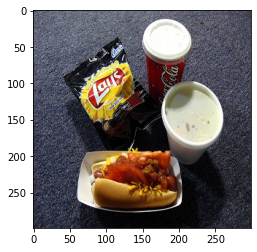

In [76]:
img = img.cpu()
plt.imshow(img[0].permute(1, 2, 0)) 

8. 모델 평가

In [77]:
def evaluation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
    with torch.no_grad():
        model.eval()
        for images, labels in testloader: 
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
            correct = (preds == labels).sum()
      
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) # 16개에 대한 loss
      
            test_accuracy += accuracy.item()
            test_loss += loss.item() # tensor 값을 꺼내옴
        
    print('Test Loss : ', test_loss/len(testloader))
    print('Test Accuracy : ', test_accuracy/len(testloader))

In [78]:
evaluation(model, testloader, criterion)

Test Loss :  0.6436451665164592
Test Accuracy :  0.8765432122680876


9. 모델 저장

In [79]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [80]:
last_state_dict = torch.load('last_checkpoint.pth')
last_state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [83]:
#last_model = AlexNet()

last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [84]:
evaluation(last_model, testloader, criterion)

Test Loss :  0.6436451665164592
Test Accuracy :  0.8765432122680876


In [82]:
best_state_dict = torch.load('best_checkpoint.pth')

In [85]:
#best_model = AlexNet()

best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [99]:
evaluation(best_model, testloader, criterion)

Test Loss :  0.7245441284030676
Test Accuracy :  0.615234375
